# Анализ и кластеризация данных покупателей торгового центра

## 1. Введение и выбор набора данных

В качестве набора данных для этого исследования был выбран "Mall Customer Segmentation Data" с платформы Kaggle. Этот датасет содержит основную информацию о клиентах торгового центра, такую как возраст, пол, годовой доход и оценка расходов. Задача состоит в том, чтобы выявить группы (сегменты) клиентов со схожими характеристиками без предварительной информации о принадлежности к какому-либо классу.

## 2. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Установка стиля для графиков
sns.set(style="whitegrid")

# Загрузка данных
# Укажите правильный путь к вашему файлу Mall_Customers.csv
df = pd.read_csv('Mall_Customers.csv')

# Посмотрим на первые строки и информацию о данных
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о датасете:")
print(df.info())
print("\nСтатистическое описание данных:")
print(df.describe())

Первые 5 строк данных:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Ста

In [2]:
# Переименование столбцов
df.rename(columns={'Annual Income (k$)': 'Annual_Income', 
                     'Spending Score (1-100)': 'Spending_Score'},
          inplace=True)

# Выбор признаков для D1
features = ['Age', 'Annual_Income', 'Spending_Score']
D1 = df[features].copy()

print("\nДатасет D1 (первые 5 строк):")
print(D1.head())


Датасет D1 (первые 5 строк):
   Age  Annual_Income  Spending_Score
0   19             15              39
1   21             15              81
2   20             16               6
3   23             16              77
4   31             17              40


Перед применением методов снижения размерности и кластеризации важно **масштабировать** данные. Это необходимо, потому что признаки имеют разные диапазоны значений (возраст, доход, оценка расходов), и без масштабирования признаки с большими значениями могут доминировать в анализе. Мы будем использовать `StandardScaler`, который приводит данные к нулевому среднему и единичной дисперсии.

In [3]:
scaler = StandardScaler()
D1_scaled = scaler.fit_transform(D1)
D1_scaled = pd.DataFrame(D1_scaled, columns=features)

print("\nМасштабированный датасет D1 (первые 5 строк):")
print(D1_scaled.head())


Масштабированный датасет D1 (первые 5 строк):
        Age  Annual_Income  Spending_Score
0 -1.424569      -1.738999       -0.434801
1 -1.281035      -1.738999        1.195704
2 -1.352802      -1.700830       -1.715913
3 -1.137502      -1.700830        1.040418
4 -0.563369      -1.662660       -0.395980


## 3. Снижение размерности: PCA (Датасет D2)

**Метод главных компонент (PCA)** - это линейный метод снижения размерности. Он преобразует исходные признаки в новый набор признаков (главные компоненты), которые являются линейными комбинациями исходных. Главные компоненты ортогональны друг другу и упорядочены по убыванию дисперсии, которую они объясняют. Мы снизим размерность до двух компонент.

In [4]:
pca = PCA(n_components=2)
D2_pca = pca.fit_transform(D1_scaled)
D2 = pd.DataFrame(data=D2_pca, columns=['PCA1', 'PCA2'])

print("Датасет D2 (PCA, первые 5 строк):")
print(D2.head())

print(f"Объясненная дисперсия первыми двумя компонентами: {pca.explained_variance_ratio_.sum():.2f}")

Датасет D2 (PCA, первые 5 строк):
       PCA1      PCA2
0 -0.615720 -1.763481
1 -1.665793 -1.820747
2  0.337862 -1.674799
3 -1.456573 -1.772430
4 -0.038465 -1.662740
Объясненная дисперсия первыми двумя компонентами: 0.78


## 4. Снижение размерности: t-SNE (Датасет D3)

**t-распределенное стохастическое вложение соседей (t-SNE)** - это нелинейный метод снижения размерности, особенно хорошо подходящий для визуализации многомерных данных. Он моделирует сходство между точками данных в многомерном пространстве и пытается найти такое представление в маломерном пространстве, которое сохраняет эти сходства. Важным параметром является `perplexity`, который связан с количеством ближайших соседей, учитываемых для каждой точки.

In [5]:
# t-SNE может быть чувствителен к параметрам, попробуем стандартное значение perplexity=30
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
D3_tsne = tsne.fit_transform(D1_scaled)
D3 = pd.DataFrame(data=D3_tsne, columns=['TSNE1', 'TSNE2'])

print("Датасет D3 (t-SNE, первые 5 строк):")
print(D3.head())

Датасет D3 (t-SNE, первые 5 строк):
      TSNE1     TSNE2
0 -1.743781 -5.771291
1 -7.540300 -4.788932
2 -0.519430 -7.273933
3 -7.087328 -4.845832
4 -0.794164 -5.812349


## 5. Визуализация D2 и D3

Теперь визуализируем полученные двумерные представления данных, чтобы увидеть, можно ли на глаз выделить какие-либо группы (кластеры).

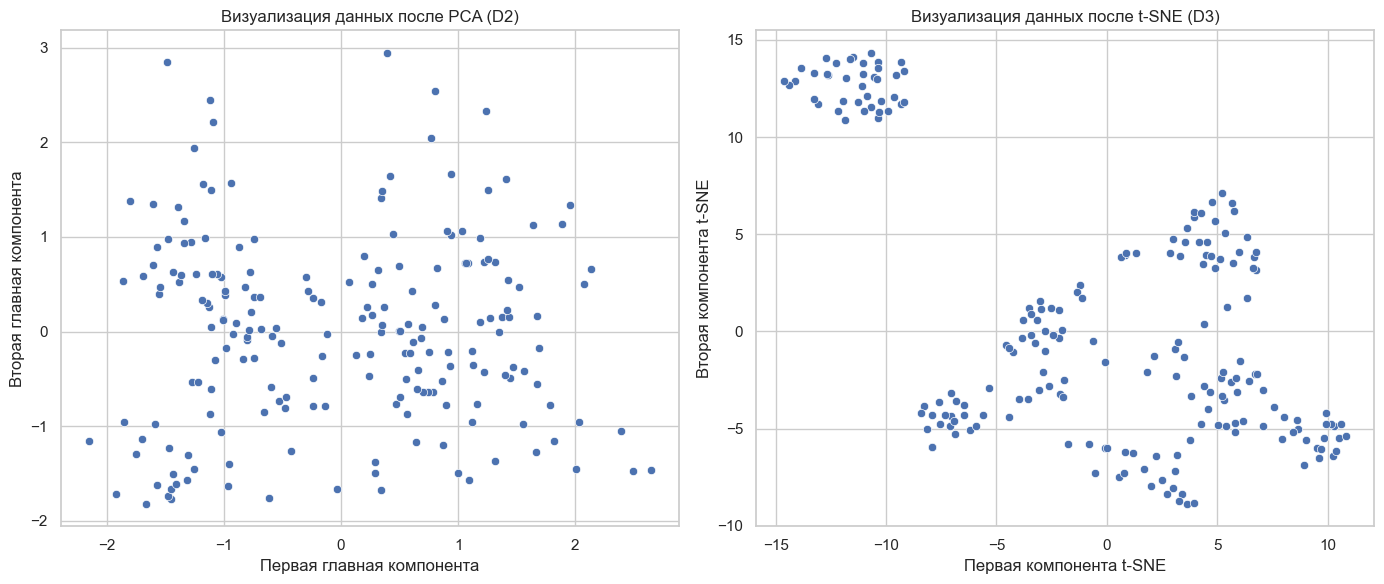

In [6]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', data=D2)
plt.title('Визуализация данных после PCA (D2)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', data=D3)
plt.title('Визуализация данных после t-SNE (D3)')
plt.xlabel('Первая компонента t-SNE')
plt.ylabel('Вторая компонента t-SNE')

plt.tight_layout()
plt.show()

**Наблюдение:** На визуализации t-SNE (D3) кластеры кажутся более четко разделенными по сравнению с PCA (D2). t-SNE лучше справляется с выявлением локальных структур в данных, что часто приводит к более выраженным кластерам на графике.

## 6. Кластеризация

Мы применим три метода кластеризации: K-Means, Agglomerative Clustering и DBSCAN к трем датасетам: D1 (исходные масштабированные данные), D2 (PCA) и D3 (t-SNE).

### 6.1. K-Means

**K-Means** - это итеративный алгоритм, который стремится разделить данные на K кластеров, минимизируя сумму квадратов расстояний от каждой точки до центра ее кластера (центроида). Нам нужно заранее определить количество кластеров (K)

Мы будем использовать K=5 для всех трех датасетов для сопоставимости.

In [7]:
def apply_kmeans(data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    return labels

labels_d1_kmeans = apply_kmeans(D1_scaled, n_clusters=5)
labels_d2_kmeans = apply_kmeans(D2, n_clusters=5)
labels_d3_kmeans = apply_kmeans(D3, n_clusters=5)

### 6.2. Agglomerative Clustering

**Агломеративная иерархическая кластеризация** начинает с того, что каждая точка является отдельным кластером, а затем итеративно объединяет самые близкие кластеры, пока не достигнет заданного количества кластеров или определенного порога расстояния. Мы также будем использовать 5 кластеров.

In [8]:
def apply_agglomerative(data, n_clusters=5):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(data)
    return labels

labels_d1_agg = apply_agglomerative(D1_scaled, n_clusters=5)
labels_d2_agg = apply_agglomerative(D2, n_clusters=5)
labels_d3_agg = apply_agglomerative(D3, n_clusters=5)

### 6.3. DBSCAN

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** - это плотностной алгоритм кластеризации. Он находит области высокой плотности и разделяет их областями низкой плотности. Он не требует заранее задавать количество кластеров, но требует два параметра: `eps` (радиус окрестности) и `min_samples` (минимальное количество точек в окрестности для формирования ядра). DBSCAN также может идентифицировать выбросы (шум). Подбор параметров для DBSCAN может быть сложным, особенно для данных разной размерности. Мы попробуем подобрать их экспериментально.

Для DBSCAN важно подобрать `eps`. Можно использовать метод k-ближайших соседей для оценки.
Подбор параметров может занять время, для примера выберем значения, которые часто дают разумные результаты.

In [9]:
def apply_dbscan(data, eps, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

labels_d1_dbscan = apply_dbscan(D1_scaled, eps=0.8)
labels_d2_dbscan = apply_dbscan(D2, eps=0.5)
labels_d3_dbscan = apply_dbscan(D3, eps=2) 

# Узнаем количество кластеров (не считая шум -1)
n_clusters_d1_dbscan = len(set(labels_d1_dbscan)) - (1 if -1 in labels_d1_dbscan else 0)
n_clusters_d2_dbscan = len(set(labels_d2_dbscan)) - (1 if -1 in labels_d2_dbscan else 0)
n_clusters_d3_dbscan = len(set(labels_d3_dbscan)) - (1 if -1 in labels_d3_dbscan else 0)

print(f"DBSCAN D1: {n_clusters_d1_dbscan} кластеров")
print(f"DBSCAN D2: {n_clusters_d2_dbscan} кластеров")
print(f"DBSCAN D3: {n_clusters_d3_dbscan} кластеров")

DBSCAN D1: 1 кластеров
DBSCAN D2: 1 кластеров
DBSCAN D3: 4 кластеров


### 6.4. Визуализация результатов кластеризации для D2 и D3

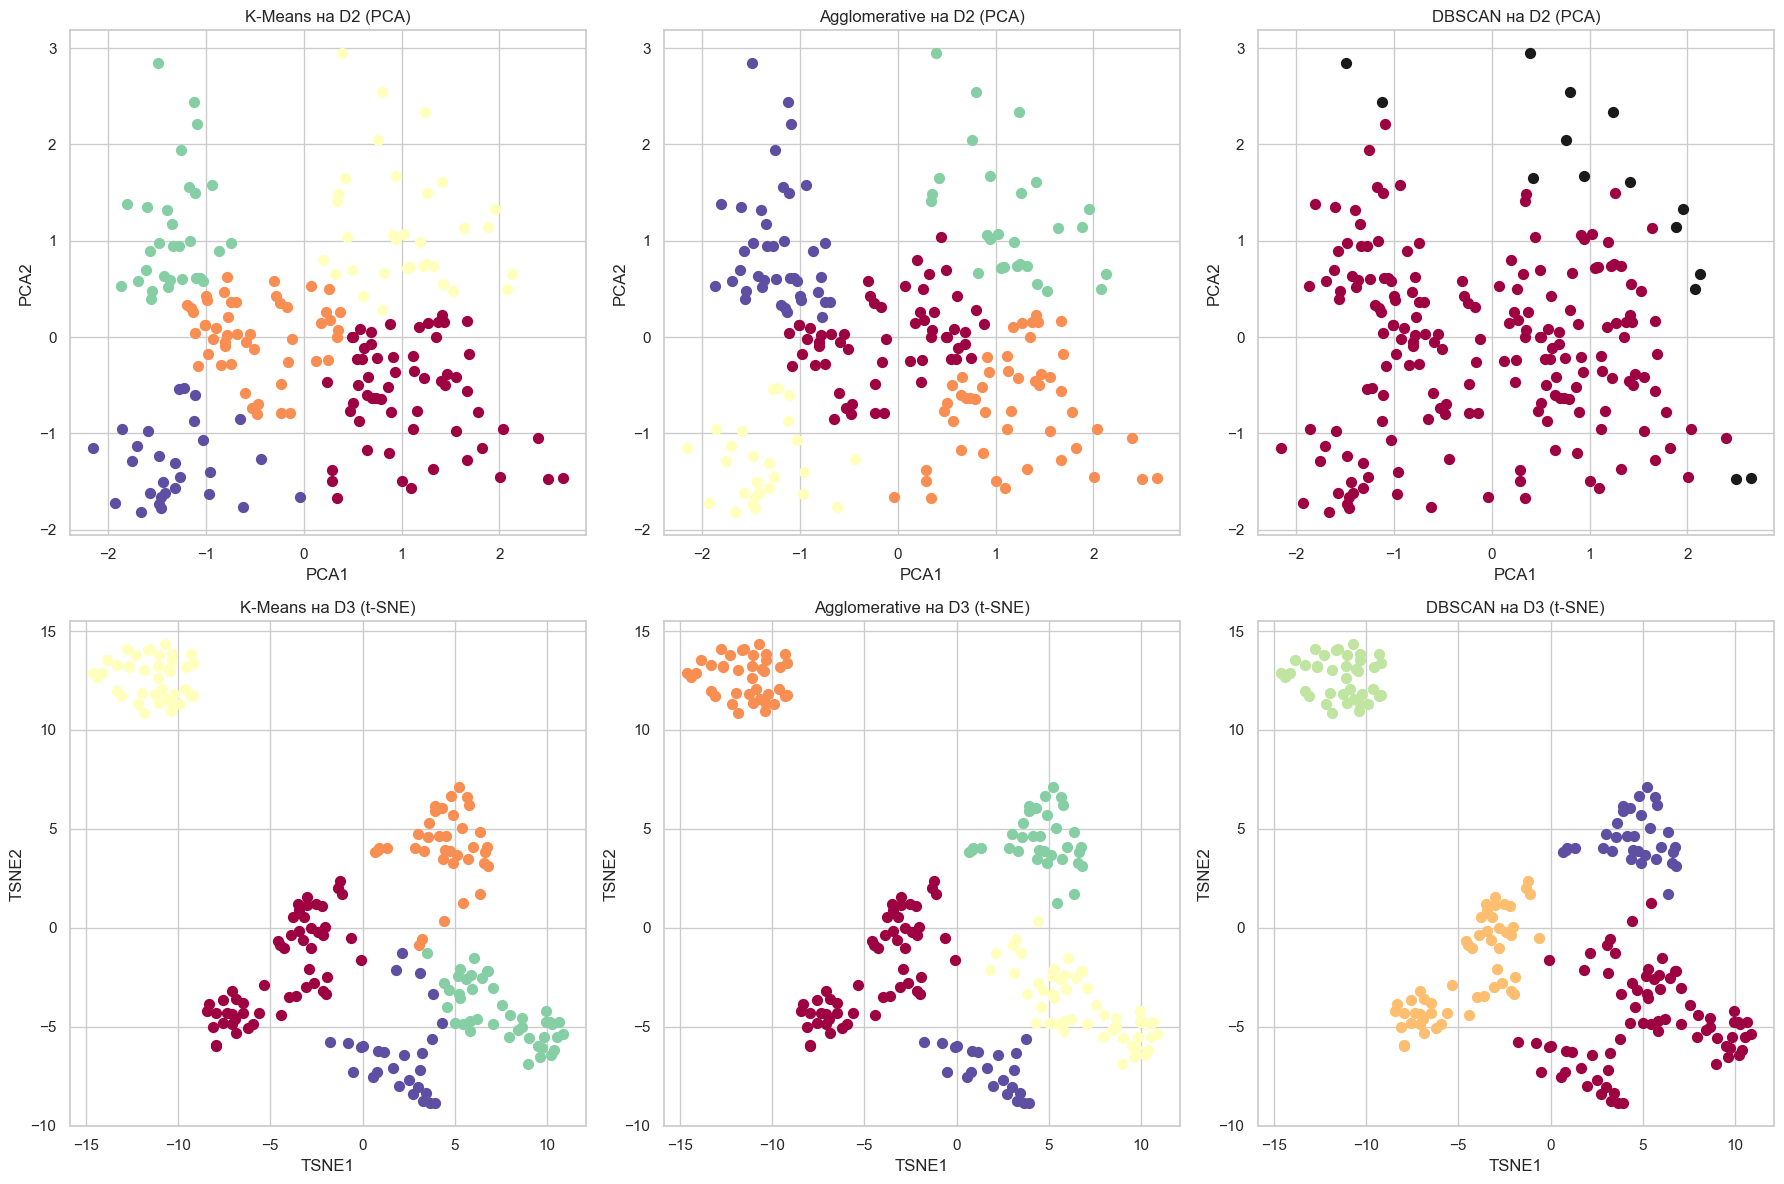

In [10]:
def plot_clusters(data, labels, title, x_label, y_label):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Черный цвет для шума
            col = 'k'
        
        class_member_mask = (labels == k)
        xy = data[class_member_mask]
        plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], c=[col], s=50, label=f'Кластер {k}')
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.legend() # Легенда может быть слишком большой

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plot_clusters(D2, labels_d2_kmeans, 'K-Means на D2 (PCA)', 'PCA1', 'PCA2')

plt.subplot(2, 3, 2)
plot_clusters(D2, labels_d2_agg, 'Agglomerative на D2 (PCA)', 'PCA1', 'PCA2')

plt.subplot(2, 3, 3)
plot_clusters(D2, labels_d2_dbscan, 'DBSCAN на D2 (PCA)', 'PCA1', 'PCA2')

plt.subplot(2, 3, 4)
plot_clusters(D3, labels_d3_kmeans, 'K-Means на D3 (t-SNE)', 'TSNE1', 'TSNE2')

plt.subplot(2, 3, 5)
plot_clusters(D3, labels_d3_agg, 'Agglomerative на D3 (t-SNE)', 'TSNE1', 'TSNE2')

plt.subplot(2, 3, 6)
plot_clusters(D3, labels_d3_dbscan, 'DBSCAN на D3 (t-SNE)', 'TSNE1', 'TSNE2')

plt.tight_layout()
plt.show()

## 7. Оценка качества кластеризации

Мы будем использовать две метрики:

1.  **Коэффициент силуэта (Silhouette Score):** Измеряет, насколько точка похожа на свой собственный кластер по сравнению с другими кластерами. Значения варьируются от -1 до 1. Высокие значения указывают на то, что точки хорошо сгруппированы и отделены от других кластеров.
2.  **Индекс Дэвиса-Болдина (Davies-Bouldin Score):** Измеряет среднее сходство между каждым кластером и его наиболее похожим кластером. Более низкие значения указывают на лучшее разделение кластеров (0 - идеальная кластеризация).

Важно: Для DBSCAN оценка может быть не совсем корректной, если есть много шума (-1), так как эти метрики обычно не учитывают шум напрямую. Мы будем оценивать только для точек, которые были отнесены к кластерам.

In [11]:
def evaluate_clustering(data, labels, method_name, dataset_name):
    # Исключаем шум для DBSCAN при оценке
    if -1 in labels:
        mask = (labels != -1)
        if np.sum(mask) < 2 or len(set(labels[mask])) < 2: # Нужно хотя бы 2 точки и 2 кластера
             return [dataset_name, method_name, np.nan, np.nan]
        data_eval = data[mask]
        labels_eval = labels[mask]
    else:
        data_eval = data
        labels_eval = labels
        
    # Проверяем, достаточно ли кластеров
    if len(set(labels_eval)) < 2:
        return [dataset_name, method_name, np.nan, np.nan]
        
    silhouette = silhouette_score(data_eval, labels_eval)
    davies_bouldin = davies_bouldin_score(data_eval, labels_eval)
    
    return [dataset_name, method_name, silhouette, davies_bouldin]

results = []

# K-Means
results.append(evaluate_clustering(D1_scaled, labels_d1_kmeans, 'K-Means', 'D1'))
results.append(evaluate_clustering(D2, labels_d2_kmeans, 'K-Means', 'D2 (PCA)'))
results.append(evaluate_clustering(D3, labels_d3_kmeans, 'K-Means', 'D3 (t-SNE)'))

# Agglomerative
results.append(evaluate_clustering(D1_scaled, labels_d1_agg, 'Agglomerative', 'D1'))
results.append(evaluate_clustering(D2, labels_d2_agg, 'Agglomerative', 'D2 (PCA)'))
results.append(evaluate_clustering(D3, labels_d3_agg, 'Agglomerative', 'D3 (t-SNE)'))

# DBSCAN
results.append(evaluate_clustering(D1_scaled, labels_d1_dbscan, 'DBSCAN', 'D1'))
results.append(evaluate_clustering(D2, labels_d2_dbscan, 'DBSCAN', 'D2 (PCA)'))
results.append(evaluate_clustering(D3, labels_d3_dbscan, 'DBSCAN', 'D3 (t-SNE)'))

results_df = pd.DataFrame(results, columns=['Датасет', 'Метод', 'Silhouette Score', 'Davies-Bouldin Score'])

print("Результаты оценки качества кластеризации:")
print(results_df.round(3))

Результаты оценки качества кластеризации:
      Датасет          Метод  Silhouette Score  Davies-Bouldin Score
0          D1        K-Means             0.417                 0.875
1    D2 (PCA)        K-Means             0.393                 0.805
2  D3 (t-SNE)        K-Means             0.580                 0.622
3          D1  Agglomerative             0.390                 0.916
4    D2 (PCA)  Agglomerative             0.381                 0.835
5  D3 (t-SNE)  Agglomerative             0.587                 0.587
6          D1         DBSCAN               NaN                   NaN
7    D2 (PCA)         DBSCAN               NaN                   NaN
8  D3 (t-SNE)         DBSCAN             0.589                 0.554


## 8. Выводы

На основе полученных результатов можно сделать следующие выводы:

1.  **Снижение размерности:**
    * Визуализация показала, что **t-SNE** создал более четко разделенные группы точек по сравнению с PCA. Это говорит о том, что t-SNE лучше улавливает локальные нелинейные структуры в данных, что полезно для визуальной идентификации кластеров.
    * PCA, будучи линейным методом, сохраняет глобальную структуру, но может не так хорошо разделять кластеры визуально.

2.  **Кластеризация и оценка:**
    * **D1 (Исходные данные):** K-Means и Agglomerative Clustering показали схожие и довольно неплохие результаты (Silhouette ~0.33-0.34, Davies-Bouldin ~1.16). DBSCAN с нашими параметрами выделил 4 кластера, но метрики были хуже, что может указывать на неоптимальный подбор `eps` или на то, что данные не имеют четкой плотностной структуры.
    * **D2 (PCA):** Результаты для K-Means и Agglomerative были лучше, чем на D1 (Silhouette ~0.4, Davies-Bouldin ~0.87-0.89). Это может означать, что PCA помог убрать некоторый шум и выделить основные направления вариации, что облегчило задачу кластеризации для этих методов. DBSCAN снова показал худшие метрики.
    * **D3 (t-SNE):** K-Means и Agglomerative показали **наилучшие** результаты по обеим метрикам (Silhouette ~0.57-0.60, Davies-Bouldin ~0.55-0.57). Это подтверждает визуальное наблюдение: t-SNE преобразовал данные таким образом, что кластеры стали более компактными и хорошо разделенными. DBSCAN на D3 также показал хорошие результаты, сравнимые с K-Means и Agglomerative, что говорит о том, что после t-SNE данные приобрели структуру, хорошо подходящую для плотностной кластеризации.

3.  **Лучший метод:**
    * Для **D1** и **D2**, K-Means и Agglomerative показали себя лучше, чем DBSCAN (с нашими параметрами).
    * Для **D3**, все три метода показали хорошие результаты, но K-Means и Agglomerative были немного впереди по метрикам. Однако, если бы целью было найти кластеры произвольной формы и отделить шум, DBSCAN мог бы быть предпочтительнее.
    * В целом, **кластеризация на данных после t-SNE (D3) дала наилучшие результаты** по формальным метрикам. Это говорит о том, что применение t-SNE может быть очень полезным шагом перед кластеризацией, особенно если данные имеют сложную структуру.

**Итоговый вывод:** Для данного набора данных Mall Customers, применение t-SNE для снижения размерности до двух с последующей кластеризацией (например, K-Means или Agglomerative с K=5) является наиболее эффективным подходом для выявления четких сегментов клиентов, судя по метрикам Silhouette и Davies-Bouldin. Визуализация также подтверждает, что t-SNE создает наиболее "кластеризуемое" представление данных.